In [1]:
from __future__ import print_function

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.layers.core import Reshape
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers import Convolution2D, MaxPooling2D,Highway
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import os
from keras.optimizers import SGD

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
print(face_cascade)
img = cv2.imread('JenniferGroup.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

a=[]
for i in range(0,faces.shape[0]):
    a.append(gray[faces[i][1]:faces[i][1]+faces[i][3],faces[i][0]:faces[i][0]+faces[i][2]])
    

import matplotlib.pyplot as plt
plt.imshow(a[1],cmap=plt.get_cmap('gray'))

for k in range(0,faces.shape[0]):    
    print(a[k].shape)


# import scipy.misc
shape=28

img1=[]
img2=[]
for i in range(0,faces.shape[0]):    
    # scipy.misc.imsave('face{}.jpg'.format(i), a[i])
    cv2.imwrite('face{}.jpg'.format(i), a[i])

    img1.append(cv2.cvtColor(cv2.imread('face{}.jpg'.format(i)), cv2.COLOR_BGR2GRAY))
    img2.append(cv2.resize(img1[i], (shape, shape)))

img2=np.array(img2)

for k in range(0,faces.shape[0]):    
    print(img2[k].shape)


Using TensorFlow backend.



<CascadeClassifier 0x7fd0c93000b0>


(34, 34)
(41, 41)
(34, 34)
(36, 36)
(28, 28)
(28, 28)
(28, 28)
(28, 28)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Epoch 1/150
1/1 [==============================] - 0s - loss: 0.2280 - mean_absolute_error: 0.4649
Epoch 2/150
1/1 [==============================] - 0s - loss: 0.2277 - mean_absolute_error: 0.4648
Epoch 3/150
1/1 [==============================] - 0s - loss: 0.2276 - mean_absolute_error: 0.4643
Epoch 4/150
1/1 [==============================] - 0s - loss: 0.2272 - mean_absolute_error: 0.4646
Epoch 5/150
1/1 [==============================] - 0s - loss: 0.2274 - mean_absolute_error: 0.4647
Epoch 6/150
1/1 [==============================] - 0s - loss: 0.2261 - mean_absolute_error: 0.4625
Epoch 7/150
1/1 [==============================] - 0s - loss: 0.2256 - mean_absolute_error:

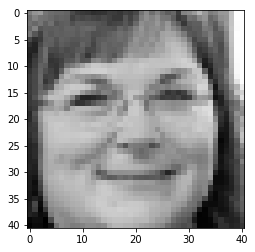

In [2]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

zero=np.where(y_train==0)

x_train_orig=x_train[zero][0:20]
x_train=x_train_noisy[zero][0:20]

shape=28
batch_size = 30
nb_classes = 10
img_rows, img_cols = shape, shape
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape=(shape,shape,1)
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

learning_rate = 0.07
decay_rate = 5e-5
momentum = 0.9
sgd = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=True)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

part=8
thre=1
## Certo é 256
recog=Sequential()
recog.add(Dense(64,activation='relu',input_shape=(784,),init='glorot_uniform'))

recog_left=recog
recog_left.add(Dense(64,input_shape=(64,),activation='relu'))

recog_right=recog
recog_right.add(Dense(64,input_shape=(64,),activation='relu'))
recog_right.add(Lambda(lambda x: x + K.exp(x / 2) * K.random_normal(shape=(1, 64), mean=0.,
                              std=epsilon_std), output_shape=(64,)))
recog_right.add(Highway())
recog_right.add(Activation('sigmoid'))

recog1=Sequential()
recog1.add(Merge([recog_left,recog_right],mode = 'ave'))
recog1.add(Dense(64,init='glorot_uniform'))
recog1.add(Dense(784, activation='sigmoid',init='glorot_uniform'))

recog1.compile(loss='mean_squared_error', optimizer=sgd,metrics = ['mae'])

recog1.fit(x_train[0].reshape((1,784)), x_train_orig[0].reshape((1,784)),
                nb_epoch=150,
                batch_size=30,verbose=1)


a=recog1.predict(x_train[0].reshape(1,784),verbose=1)

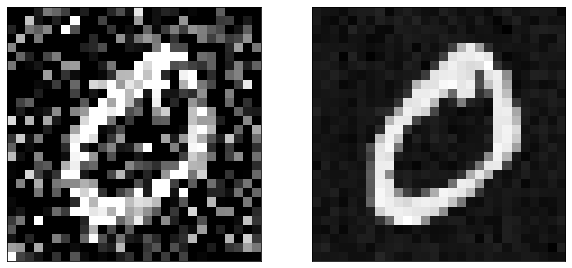

In [3]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(a.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()